<a href="https://colab.research.google.com/github/shin0105/4YP/blob/main/nursery_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install GPyOpt --quiet
!pip install GPy --quiet

In [2]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing

In [3]:
#dataset = UCI nursery 
names=['parents','has_nurs','form','children','housing','finance','social','health','class']
df = pd.read_csv('nursery.data', names = names)

In [4]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()

for col in names: 
  df[col] = le.fit_transform(df[col])

In [5]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [6]:
#K-fold validation
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [7]:
#Random Forest classification

#max_features: 1 to around sqrt(# of features of dataset)
bounds = [
        {'name': 'max_features', 'type': 'continuous', 'domain': (1, 6)},
        {'name': 'n_estimators', 'type': 'continuous', 'domain': (2, 200)}
      ]

def rf_score(parameters):
  params = {
        'max_features':int(parameters[0][0]),
        'n_estimators':int(parameters[0][1])
    }
  
  clf = RandomForestClassifier(max_features=params['max_features'],n_estimators=params['n_estimators'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  return score

In [8]:
def BO(model,kernel):
  optimizer = GPyOpt.methods.BayesianOptimization(f=model, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )
  optimizer.run_optimization(max_iter=100)
  #maximum accuracy score
  acc_max=optimizer.fx_opt
  #best parameters
  params_best=optimizer.x_opt
  print(acc_max)
  print(params_best)
  optimizer.plot_convergence()
  optimizer.plot_acquisition()

-0.9926141027446829
[  6.         129.22464318]


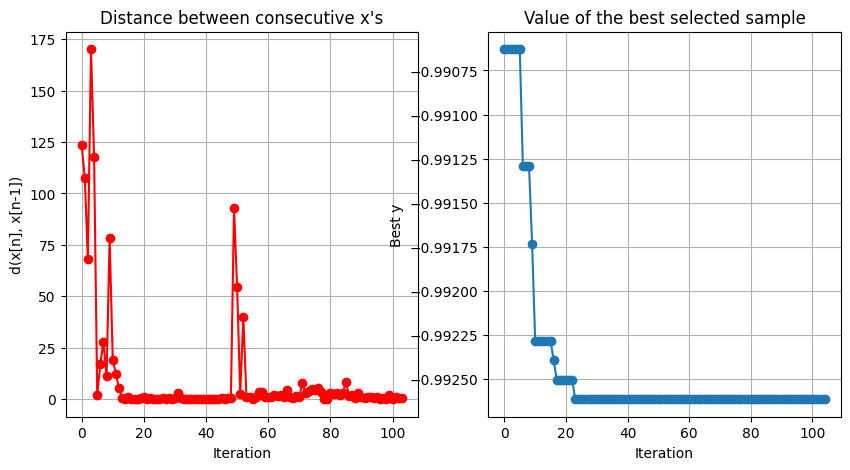

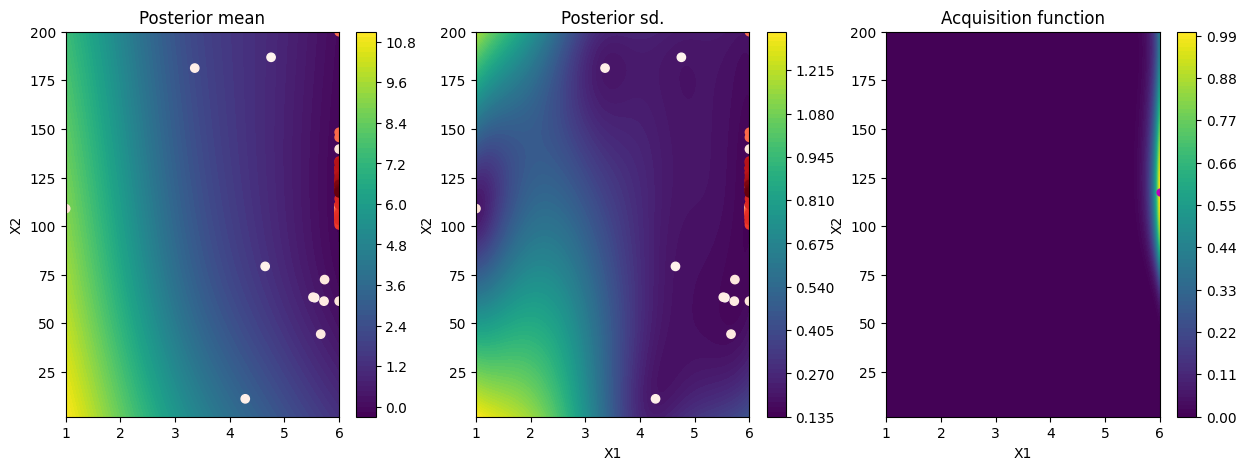

In [9]:
#RF Classification - Matern52 kernel
kernelM = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[0]) * GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[1])
BO(rf_score,kernelM)

In [10]:
meanacc=[]
for i in range(5):
  rf_car = RandomForestClassifier(max_features=6,n_estimators=129)
  rf_car.fit(X_train,y_train)
  y_pred = rf_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.9951131687242798
0.9935699588477366
0.9945987654320988
0.9935699588477366
0.9945987654320988
mean accuracy 0.9942901234567902


-0.9928346099111657
[  6.         160.92604757]


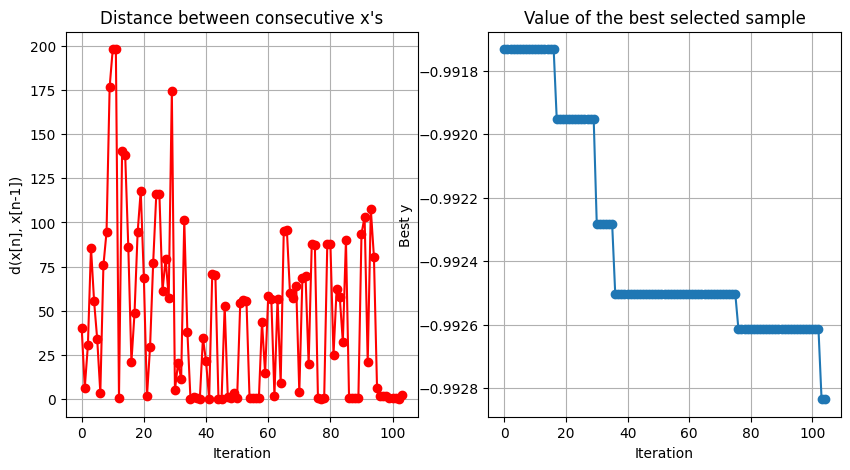

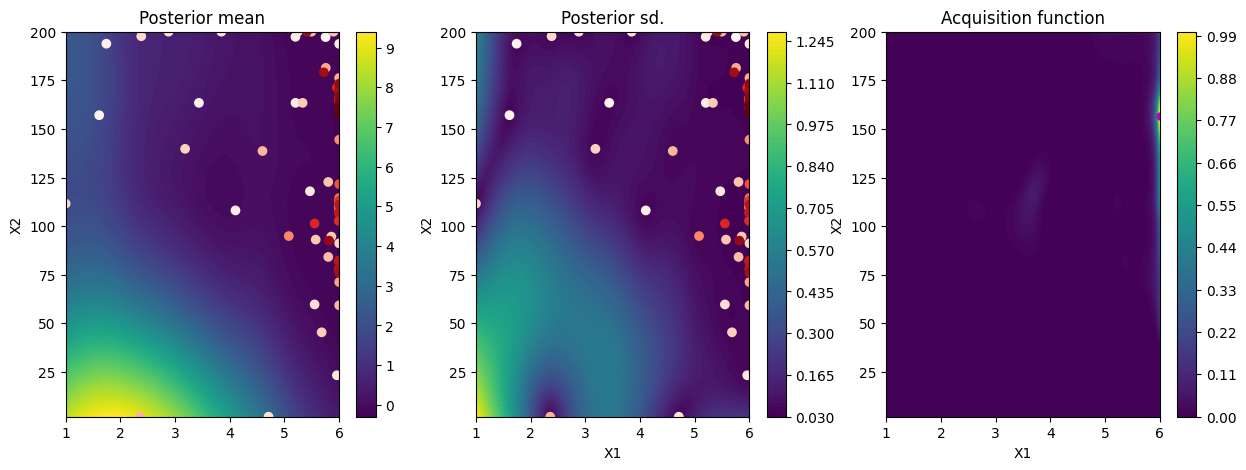

In [12]:
#RF Classification - Custom kernel
kernel1 = GPy.kern.Matern52(input_dim=1,variance=0.44,lengthscale=18,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=1.66e-12,lengthscale=5.43,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=0.2655,lengthscale=9.696,active_dims=[0]) \
        * GPy.kern.Matern52(input_dim=1,variance=0.2655,lengthscale=56.74,active_dims=[1])
kernelR = kernel1 + kernel2 + kernel3
BO(rf_score,kernelR)

In [20]:
meanacc=[]
for i in range(5):
  rf_car = RandomForestClassifier(max_features=6,n_estimators=161)
  rf_car.fit(X_train,y_train)
  y_pred = rf_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.9938271604938271
0.9948559670781894
0.9945987654320988
0.9933127572016461
0.9935699588477366
mean accuracy 0.9940329218106996


In [13]:
#SVM Classification

bounds = [ {'name': 'C', 'type': 'continuous', 'domain': (0.1, 100)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0.01, 1)}
      ]


def svm_score(parameters):
  params = {
        'C': parameters[0][0],
        'gamma': parameters[0][1]
    }
  
  clf = svm.SVC(C=params['C'],gamma=params['gamma'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)

  return score

-0.999007839175478
[100.          0.1138881]


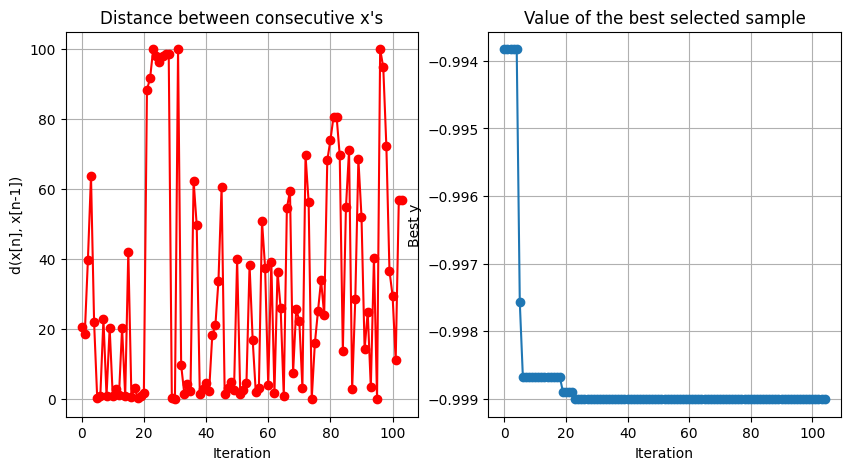

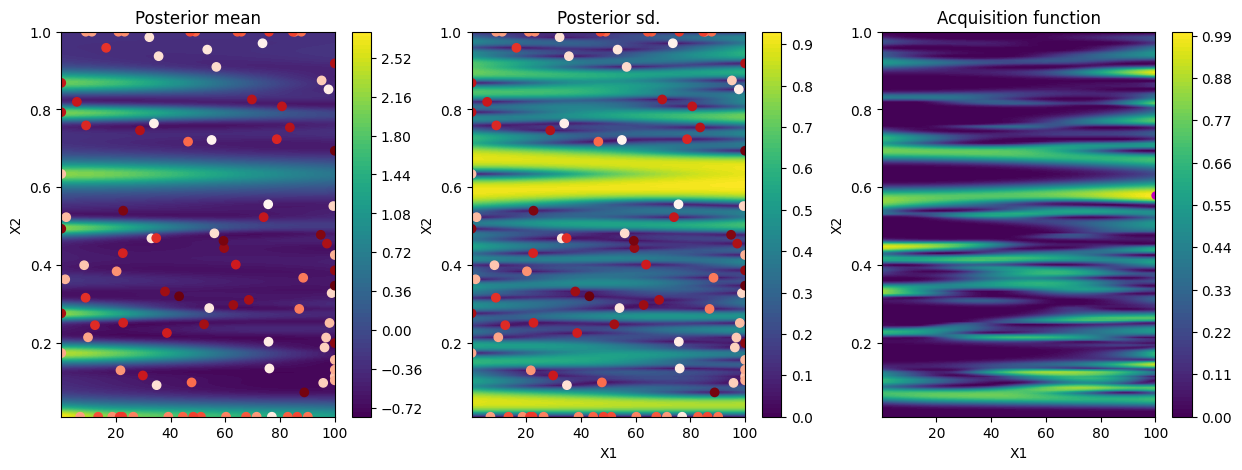

In [14]:
#SVM Classification - Matern52 kernel
kernel1 = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[0]) * GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[1])
BO(svm_score,kernel1)

In [21]:
meanacc=[]
for i in range(5):
  svm_car = svm.SVC(C=100,gamma=0.1138881)
  svm_car.fit(X_train,y_train)
  y_pred = svm_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.9992283950617284
0.9992283950617284
0.9992283950617284
0.9992283950617284
0.9992283950617284
mean accuracy 0.9992283950617284


-0.9988977070168877
[72.42654069  0.11926129]


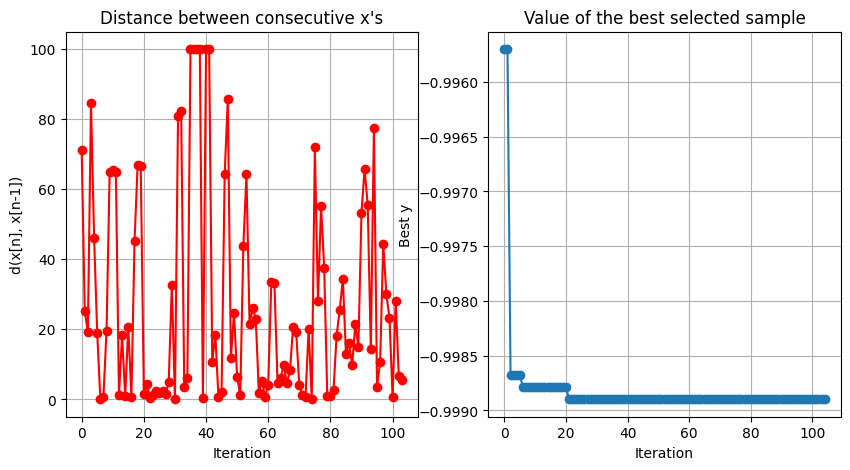

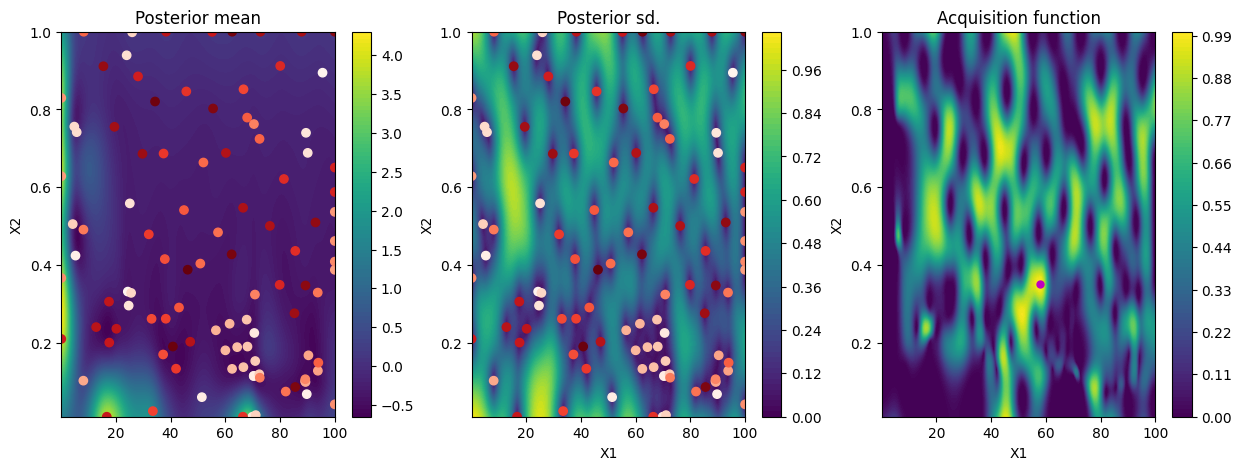

In [15]:
#SVM Classification - Custom kernel
kernelS = GPy.kern.Matern52(input_dim=1, variance=0.75558	, lengthscale=5.528,active_dims=[0]) * GPy.kern.Matern52(input_dim=1, variance=0.75558, lengthscale=0.4553,active_dims=[1])
BO(svm_score,kernelS)

In [22]:
meanacc=[]
for i in range(5):
  svm_car = svm.SVC(C=72.42654069,gamma=0.11926129)
  svm_car.fit(X_train,y_train)
  y_pred = svm_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.9989711934156379
0.9989711934156379
0.9989711934156379
0.9989711934156379
0.9989711934156379
mean accuracy 0.9989711934156379


In [16]:
#KNN Classification

#search domain
bounds = [ {'name': 'leaf_size', 'type': 'continuous', 'domain': (1, 100)},
        {'name': 'n_neighbors', 'type': 'discrete', 'domain': (3,4,5,6,7)}
      ]


def knn_score(parameters):
  params = {
        'leaf_size': int(parameters[0][0]),
        'n_neighbors':int(parameters[0][1])
    }
  
  clf = KNeighborsClassifier(leaf_size=params['leaf_size'],n_neighbors=params['n_neighbors'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)

  return score

-0.9501760657441631
[12.59161793  7.        ]


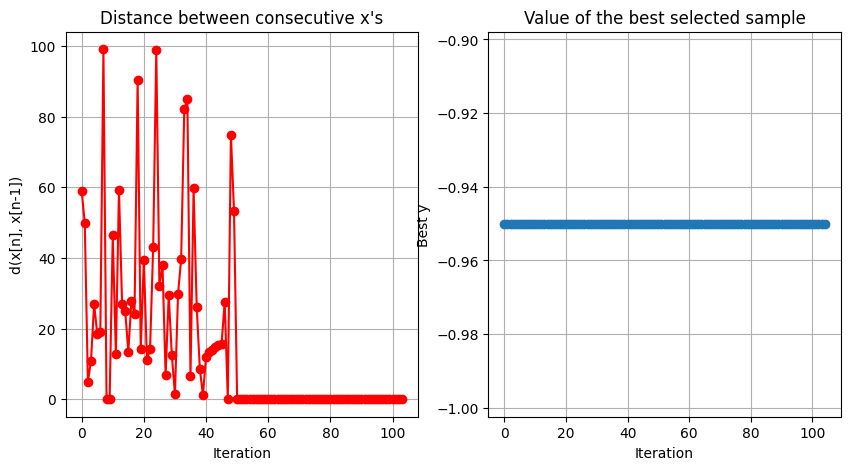

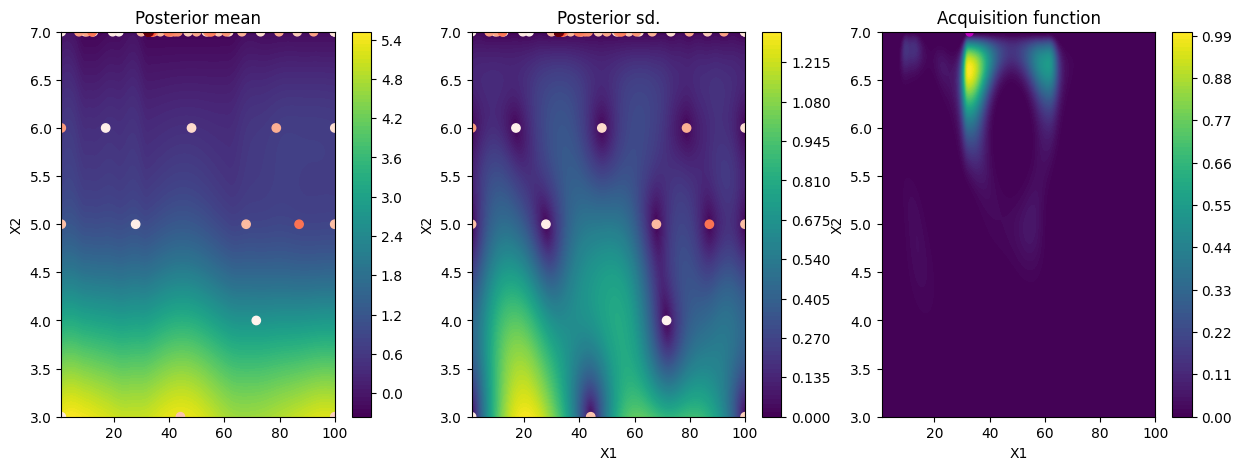

In [17]:
#KNN Classification - Matern52 kernel
kernelK = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[0]) * GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[1])
BO(knn_score,kernelK)

In [23]:
meanacc=[]
for i in range(5):
  knn_car = KNeighborsClassifier(leaf_size=13,n_neighbors=7)
  knn_car.fit(X_train,y_train)
  y_pred = knn_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.9503600823045267
0.9503600823045267
0.9503600823045267
0.9503600823045267
0.9503600823045267
mean accuracy 0.9503600823045268


-0.9501760657441631
[10.80910909  7.        ]


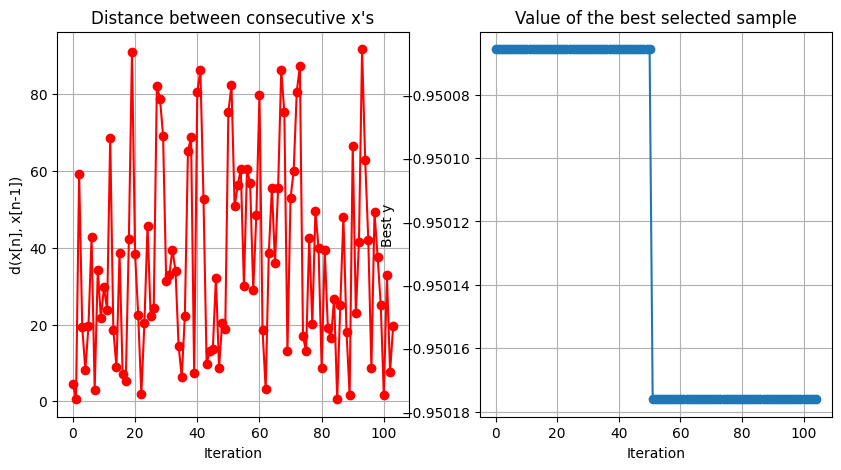

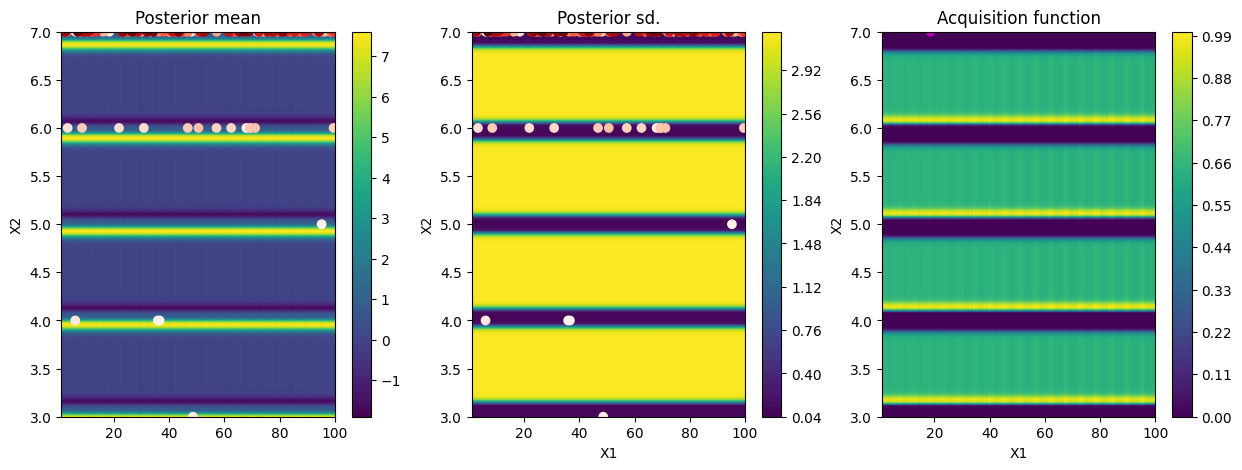

In [18]:
kernel1 = GPy.kern.StdPeriodic(input_dim=1,variance=9.31e-09,lengthscale=71.5,active_dims=[0],period=13)
kernel2 = GPy.kern.StdPeriodic(input_dim=1,variance=0.3117,lengthscale=1.67,active_dims=[1],period=2)
kernelK = kernel1 + kernel2
BO(knn_score,kernelK)

In [24]:
meanacc=[]
for i in range(5):
  knn_car = KNeighborsClassifier(leaf_size=11,n_neighbors=7)
  knn_car.fit(X_train,y_train)
  y_pred = knn_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.9503600823045267
0.9503600823045267
0.9503600823045267
0.9503600823045267
0.9503600823045267
mean accuracy 0.9503600823045268


-0.9501760657441631
[9.65924052 7.        ]


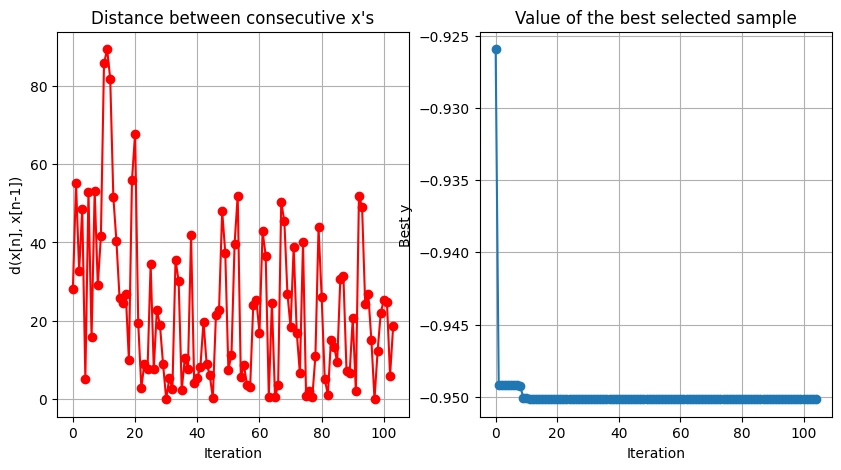

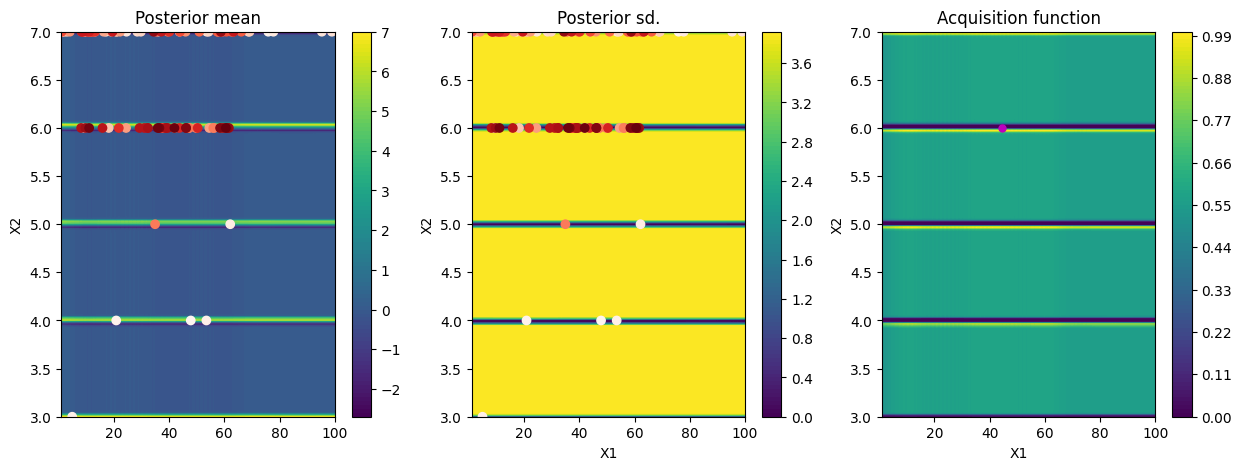

In [19]:
kernel1 = GPy.kern.StdPeriodic(input_dim=1,variance=4.372e-14	,lengthscale=1.00,active_dims=[0],period=13) \
          * GPy.kern.Matern52(input_dim=1,variance = 4.372e-14,lengthscale=1.018,active_dims=[0])
kernel2 = GPy.kern.StdPeriodic(input_dim=1,variance=0.3117,lengthscale=1.789,active_dims=[1],period=2)
kernelK = kernel1 + kernel2
BO(knn_score,kernelK)

In [25]:
meanacc=[]
for i in range(5):
  knn_car = KNeighborsClassifier(leaf_size=10,n_neighbors=7)
  knn_car.fit(X_train,y_train)
  y_pred = knn_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.9503600823045267
0.9503600823045267
0.9503600823045267
0.9503600823045267
0.9503600823045267
mean accuracy 0.9503600823045268
